In [1]:
pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.11.0


In [4]:
# dataset from UCI ML repo - Auto MPG dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail() # show

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna() # drop nulls for tutorial purposes

In [8]:
# map data of origin, as 1 = USA etc.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

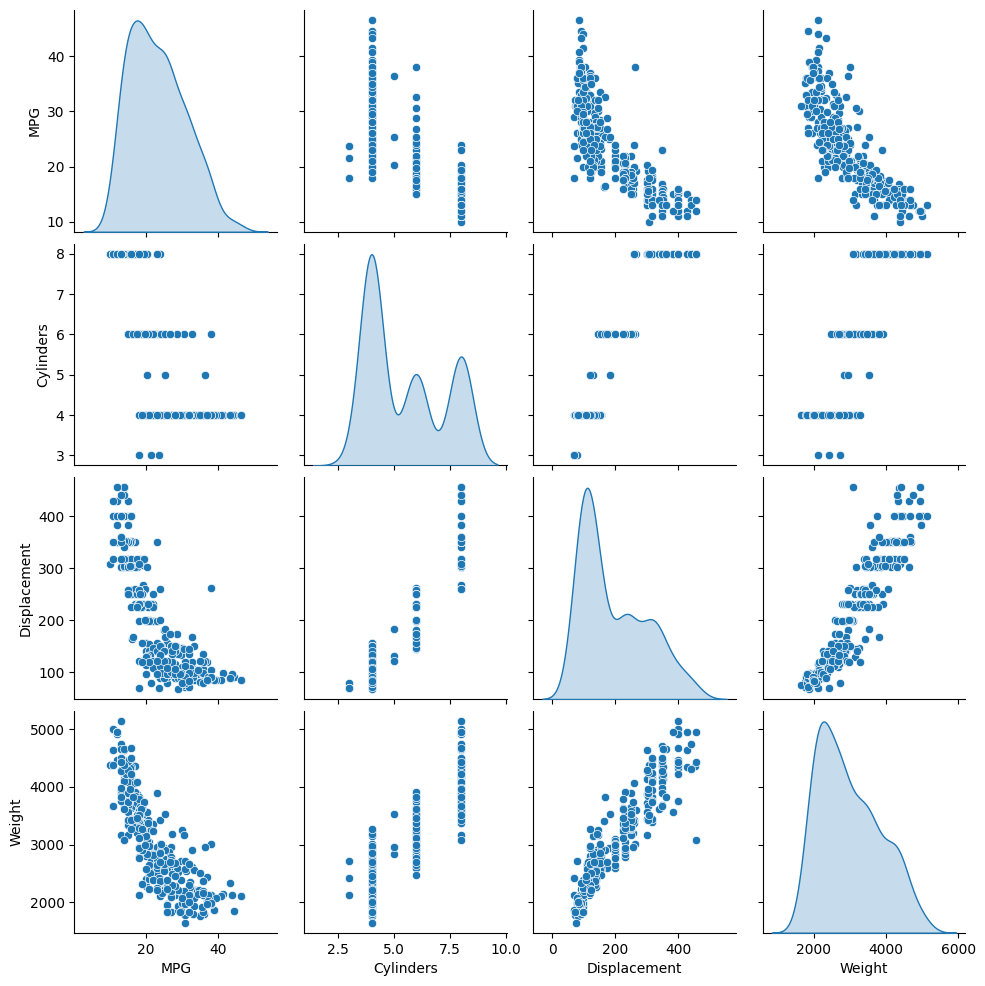

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
# show overall stats
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [13]:
# separate target val from label, train such that the model can predict the val
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [15]:
# create normalizer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [17]:
# DNN example -----
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [18]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [19]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 159ms/step


array([[-0.038],
       [-0.021],
       [ 0.07 ],
       [-0.053],
       [-0.048],
       [-0.019],
       [-0.057],
       [-0.048],
       [-0.012],
       [-0.021]], dtype=float32)

In [20]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [21]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2) # calc validates 20pct. of the training data

CPU times: total: 4.67 s
Wall time: 4.08 s


In [22]:
# visualize the model as such:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.805877,4.180989,95
96,3.802654,4.195199,96
97,3.802217,4.194726,97
98,3.804267,4.174486,98
99,3.803648,4.192851,99


In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

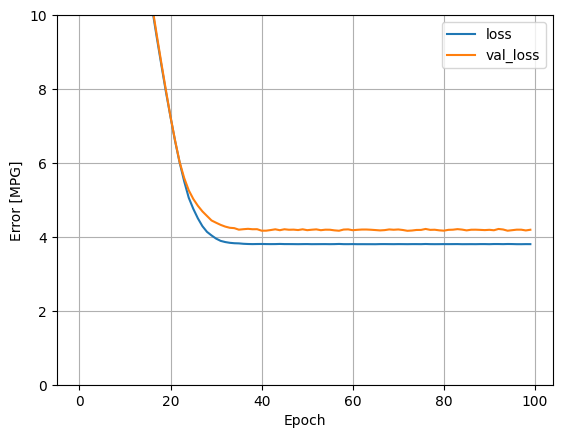

In [25]:
plot_loss(history)

In [26]:
# collect results on test set for later use
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [28]:
# singlge var regression
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [29]:
# watch model as such:
def plot_horsepower(x,y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x,y,color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

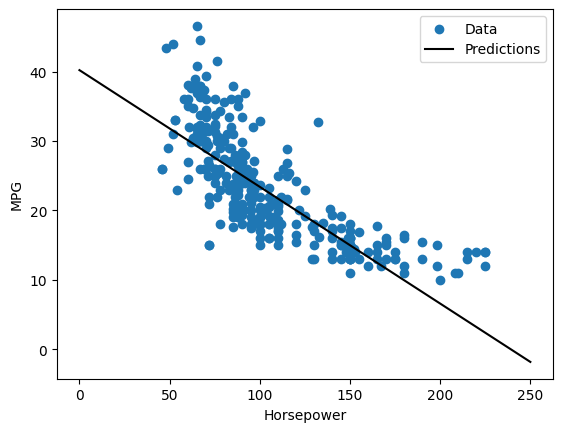

In [30]:
plot_horsepower(x, y)

In [31]:
# Linear Regression with multiple inputs
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [33]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 70ms/step


array([[-0.913],
       [-1.266],
       [ 3.547],
       [-1.67 ],
       [-3.983],
       [-0.152],
       [-4.355],
       [-1.946],
       [ 0.181],
       [-3.322]], dtype=float32)

In [34]:
#built by y=mx+b, where m has the shape (9,1)
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.362],
       [ 0.537],
       [ 0.571],
       [ 0.223],
       [-0.623],
       [-0.28 ],
       [ 0.484],
       [-0.429],
       [ 0.326]], dtype=float32)>

In [35]:
# use keras to train the model and fit data during 100 epochs
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [37]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2)

CPU times: total: 4.84 s
Wall time: 4.12 s


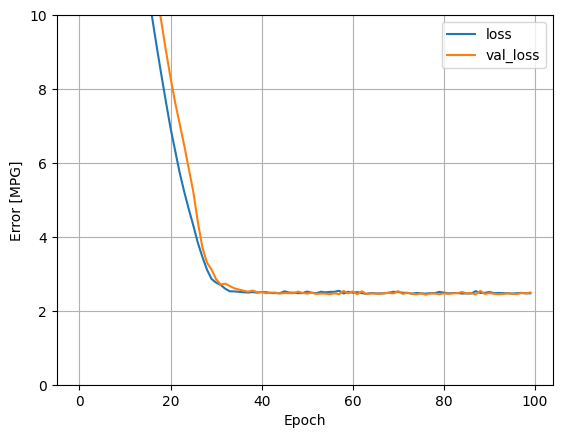

In [38]:
plot_loss(history)

In [39]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)